# Répartir en base d'apprentissage et de test

C'est un problème plutôt facile puisqu'il s'agit de répartir aléatoirement les lignes d'une base de données d'un côté ou de l'autre. Lorsque le problème de machine learning à résoudre est un problème de classification, il faut s'assurer que chaque côté contient une proportion raisonnable de chaque classe.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Répartition naïve

On considère une base de données qu'on divise en 2/3 apprentissage, 1/3 test. On note cette proportion $t$. Deux classes 0 et 1, la proportion de la classe 1 est de $p$ qu'on choisit petit.

In [3]:
import random
def generate_dataset(n, t):
    return [1 if random.random() < t else 0 for i in range(0,n)]

ens = generate_dataset(4000, 0.01)
sum(ens)

49

Et on divise en base d'apprentissage et de test.

In [4]:
def custom_split_train_test(ens, p):
    choice = generate_dataset(len(ens), p)
    train = [x for x, c in zip(ens, choice) if c == 1]
    test = [x for x, c in zip(ens, choice) if c == 0]
    return train, test

train, test = custom_split_train_test(ens, 0.66)
print(len(train), sum(train), sum(train)/len(train))
print(len(test), sum(test), sum(test)/len(test))

2617 31 0.011845624761176921
1383 18 0.013015184381778741


On recommence un grand nombre de fois et on représente la proportion obtenue dans la base de test.

In [5]:
tirages = [sum(test)/len(test) for train, test in [custom_split_train_test(ens, 0.66) for i in range(0,100)]]

Text(0.5,0,'tirages')

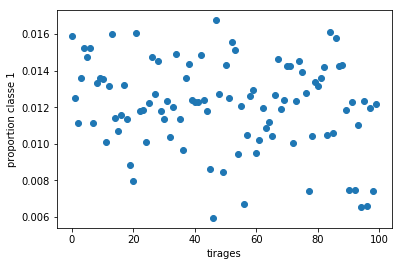

In [6]:
plt.plot(tirages, "o")
plt.ylabel("proportion classe 1")
plt.xlabel("tirages")

On considère maintenant la moyenne, les valeurs extrêmes de la proportion en faisant varier $p$.

In [7]:
ps = [0.001 * i for i in range(1, 50)]
tmin, tmax, tmean = [], [], []
for p in ps:
    ens = generate_dataset(4000, p)
    tirages = [sum(test)/len(test) for train, test in [custom_split_train_test(ens, 0.66) for i in range(0,200)]]
    tirages.sort()
    tmin.append(tirages[int(len(tirages)*0.05)])
    tmax.append(tirages[-int(len(tirages)*0.05)])
    tmean.append(sum(tirages) / len(tirages))

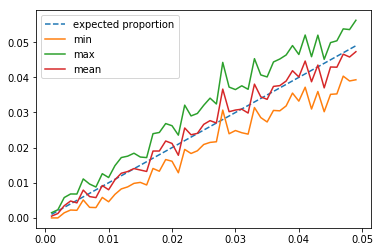

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(ps, ps, "--", label="expected proportion")
ax.plot(ps, tmin, label="min")
ax.plot(ps, tmax, label="max")
ax.plot(ps, tmean, label="mean")
ax.legend()

Et [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)...

In [9]:
from sklearn.model_selection import train_test_split
import pandas

ps = [0.001 * i for i in range(1, 50)]
tmin, tmax, tmean = [], [], []
for p in ps:
    ens = pandas.Series(generate_dataset(4000, p))
    tirages = [sum(test)/len(test) for train, test in [train_test_split(ens, test_size=0.66) for i in range(0,200)]]
    tirages.sort()
    tmin.append(tirages[int(len(tirages)*0.05)])
    tmax.append(tirages[-int(len(tirages)*0.05)])
    tmean.append(sum(tirages) / len(tirages))

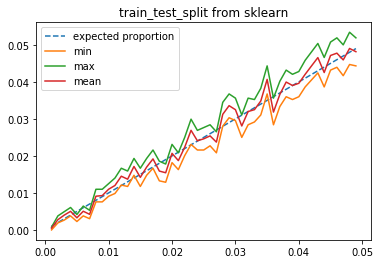

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(ps, ps, "--", label="expected proportion")
ax.plot(ps, tmin, label="min")
ax.plot(ps, tmax, label="max")
ax.plot(ps, tmean, label="mean")
ax.set_title("train_test_split from sklearn")
ax.legend()

L'écart entre les extrêmes paraît plus petit. Le générateur pseudo aléatoire utilisé par [scikit-learn](http://scikit-learn.org/) paraît de meilleur qualité. Nous y reviendront peut-être un jour.

## Répartition stratifiée

Nous utilisons maintenant le paramètre *stratify* qui permet de s'assurer que les deux classes sont équitablement réparties entre les deux ensembles *train* et *test*.

In [11]:
from sklearn.model_selection import train_test_split
import pandas

ps = [0.001 * i for i in range(1, 50)]
tmin, tmax, tmean = [], [], []
for p in ps:
    ens = pandas.Series(generate_dataset(4000, p))
    
    traintest = []
    excs = []
    for i in range(0, 200):
        try:
            train, test = train_test_split(ens, test_size=0.66, stratify=ens)
            traintest.append((train,test))
        except ValueError as e:
            print("Skipping: small class too small in one side", e)
            excs.append(e)
    if len(traintest) < 100:
        ex = excs[0] if len(excs) > 0 else "no exception"
        raise Exception("Too few, you should check the implementation is ok.\n{0}".format(ex))
    tirages = [sum(test)/len(test) for train, test in traintest]
    tirages.sort()
    tmin.append(tirages[int(len(tirages)*0.05)])
    tmax.append(tirages[-int(len(tirages)*0.05)])
    tmean.append(sum(tirages) / len(tirages))

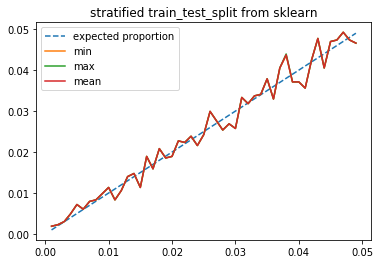

In [12]:
fig, ax = plt.subplots(1, 1)
ax.plot(ps, ps, "--", label="expected proportion")
ax.plot(ps, tmin, label="min")
ax.plot(ps, tmax, label="max")
ax.plot(ps, tmean, label="mean")
ax.set_title("stratified train_test_split from sklearn")
ax.legend()

La proportion initiale est bien respectée. Comment faire cela en pratique ? Le plus simple est sans doute de :

* De trier les observations qui appartiennent à chaque classe.
* De les permuter de façon aléatoire.
* Puis de prendre les premiers éléments pour la base d'apprentissage dans chaque classe et les derniers pour la base de test.

In [13]:
def custom_statitied_split_train_test(ens, p, stratify):
    strat = set(stratify)
    train = []
    test = []
    for st in strat:
        cl = [e for e, s in zip(ens, stratify) if s == st]
        random.shuffle(cl)
        i = int(len(cl) * p)
        train.extend(cl[:i])
        test.extend(cl[i:])
    return train, test

In [14]:
ps = [0.001 * i for i in range(1, 50)]
tmin, tmax, tmean = [], [], []
for p in ps:
    ens = generate_dataset(4000, p)
    tirages = [sum(test)/len(test) for train, test in [custom_statitied_split_train_test(ens, 
                        p=0.66, stratify=ens) for i in range(0,200)]]
    tirages.sort()
    tmin.append(tirages[int(len(tirages)*0.05)])
    tmax.append(tirages[-int(len(tirages)*0.05)])
    tmean.append(sum(tirages) / len(tirages))

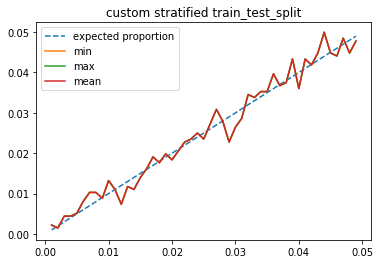

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(ps, ps, "--", label="expected proportion")
ax.plot(ps, tmin, label="min")
ax.plot(ps, tmax, label="max")
ax.plot(ps, tmean, label="mean")
ax.set_title("custom stratified train_test_split")
ax.legend()

La méthode est simple mais plus coûteuse puisqu'elle nécessite un tri.

In [16]:
import time

ns = []
tn = []
ts = []

ii = 5
for N in [10000, 20000, 50000, 100000, 200000, 500000, int(1e6),
          int(2e6), int(5e6)]:
    print(N)
    ens = pandas.Series(generate_dataset(N, 0.05))
    ns.append(N)
    
    tt = []
    for i in range(0,ii):
        t = time.clock()
        train_test_split(ens, test_size=0.66)
        d = 1.0 * (time.clock()-t) / ii
        tt.append(d)
    tt.sort()
    tn.append(tt[len(tt)//2])
    
    tt = []
    for i in range(0,ii):
        t = time.clock()
        train_test_split(ens, test_size=0.66, stratify=ens)
        d = 1.0 * (time.clock()-t) / ii
        tt.append(d)
    tt.sort()
    ts.append(tt[len(tt)//2])


10000
20000
50000
100000
200000
500000
1000000
2000000
5000000


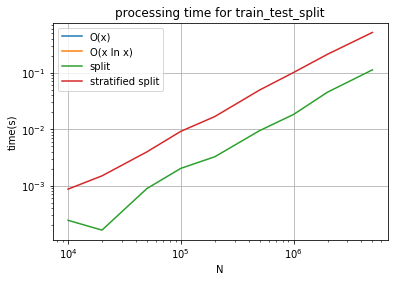

In [17]:
import math
fig, ax = plt.subplots(1, 1)
dd = tn[-1] - (ts[-1] - tn[-1])*1.3
ax.plot(ns, [x * dd / ns[-1] for x in ns], label="O(x)")
ax.plot(ns, [x * math.log(x) * ns[0] * dd / ns[-1] / (ns[0] * math.log(ns[0])) for x in ns], label="O(x ln x)")
ax.plot(ns, tn, label="split")
ax.plot(ns, ts, label="stratified split")
ax.set_title("processing time for train_test_split")
ax.grid(True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_xlabel("N")
ax.set_ylabel("time(s)")
ax.legend()

Le coût de la fonction [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) semble être entre $O(n)$ et $O(n \ln n)$. Regardons.

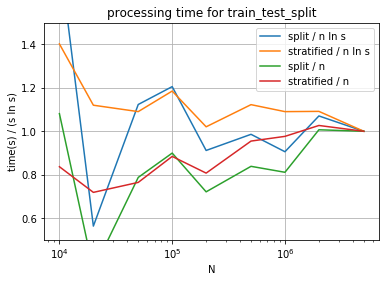

In [18]:
import math
fig, ax = plt.subplots(1, 1)
ax.plot(ns, [(x / tn[-1]) / (n * math.log(n) / (ns[-1] * math.log(ns[-1]))) for x, n in zip(tn, ns)], 
        label="split / n ln s")
ax.plot(ns, [(x / ts[-1]) / (n * math.log(n) / (ns[-1] * math.log(ns[-1]))) for x, n in zip(ts, ns)], 
        label="stratified / n ln s")
ax.plot(ns, [(x / tn[-1]) / (n / ns[-1]) for x, n in zip(tn, ns)], label="split / n")
ax.plot(ns, [(x / ts[-1]) / (n / ns[-1]) for x, n in zip(ts, ns)], label="stratified / n")

ax.set_title("processing time for train_test_split")
ax.grid(True)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("N")
ax.set_ylabel("time(s) / (s ln s)")
ax.set_ylim([0.5,1.5])
ax.legend()

C'est difficile à voir sur ce schéma. Il faudrait tirer plus d'exemple, regader les quantiles plutôt que la seule médiane. Le [code de scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py#L1048) est plus explicite, une permutation précède la répartition en train / test.

## Streaming splitting

Streaming veut dire qu'on traite les données sous la forme d'un flux et qu'on ne sait pas combien il y en. Concrètement, il faut commencer la répartition train / test au moment sans savoir quand elle s'arrêtera. Par conséquent, il faut qu'à tout instant, on soit capable d'interrompre la répartition et celle-ci doit être valide.

Le premier algorithme qui consiste à tirer un nombre aléatoire et à le répartir en train ou test selon le nombre tiré. Chaque observation est traitée indépendamment. A tout moment, la répartition peut être interrompue. En pratique, on implémente ce type de processus sous la forme d'itérateur ou de mapper. C'est une fonction qui accepte un itérateur sur un ensemble et qui retourne un itérateur sur les valeurs transformées. Dans notre cas, on retourne l'observation, suivi de 0 si elle est classée en *train* et 1 en *test*.

In [19]:
def streaming_split_train_test(stream, p):
    for obs in stream:
        x = random.random()
        yield obs, 0 if x <= p else 1

In [20]:
def iterate_data(n, t):
    while n > 0:
        yield 1 if random.random() < t else 0
        n -= 1

for obs, s in streaming_split_train_test(iterate_data(10, 0.05), 0.66):
    print("obs={0} train/test={1}".format(obs, s))

obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=0
obs=0 train/test=1
obs=0 train/test=0


La répartition stratifiée repose sur une permutation aléatoire et cela implique d'avoir accès à l'intégralité des données au préalable. En *streaming*, ce n'est pas possible. Il faut donc penser à autre chose pour obtenir une version stratifiée de la version *streaming*. Rien n'empêche en version *streaming* de garder les dernières observations en mémoire pour faire une mini-permutation. Nous allons introduire quelques changements :

1. Le *stream* est maintenant un flux sur deux valeurs, l'observation et la classe à laquelle il appartient.
2. La fonction va conserver les dernières valeurs pour chaque classe.
3. La fonction va produire des observations de temps en temps quand elle sera sûre que les observations seront stratifiées.
4. Nuos allons compter les observations distribuées dans chaque base.

In [21]:
def streaming_stratified_split_train_test(stream, p):
    n = max(1/p, 1/(1-p))
    if n > 10000:
        raise Exception("Cette répartition train / test est vraiment déséquilibrée.")
    memory = {}
    for obs, strat in stream:
        if strat not in memory:
            memory[strat] = []
        memory[strat].append(obs)

        for k in memory:
            v = memory[k]
            if len(v) >= n:
                # on permute aléatoirement
                random.shuffle(v)
                i = int(len(v) * p + 0.5)
                for j in range(0,i):
                    yield v[j], 0  # apprentissage
                for j in range(i,len(v)):
                    yield v[j], 1  # test
                # on efface de la mémoire les informations produites
                memory[k] = []

    # lorsqu'on a fini, il faut tout de même répartir les 
    # observations stockées
    for k in memory:
        v = memory[k]
        # on permute aléatoirement
        random.shuffle(v)
        i = int(len(v) * p)
        for j in range(0,i):
            yield v[j], 0  # apprentissage
        for j in range(i,len(v)):
            yield v[j], 1  # test

In [22]:
iter = streaming_stratified_split_train_test( ((i,i) for i in iterate_data(10000, 0.05)), 0.66)
df = pandas.DataFrame(iter)
df.columns = ["obs", "train_test"]
print(df.shape)
df.head()

(10000, 2)


,obs,train_test
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0


In [23]:
df2 = df.copy()
df2["un"] = 1
piv = df2.groupby(["obs", "train_test"], as_index=False).count().pivot("train_test", "obs", "un")
piv

obs,0,1
train_test,,
0,6313,353
1,3157,177


Il y a juste un petit problème avec cette implémentation. On multiplie la taille du buffer par un réel. Je suggère d'enlever le nombre 0.5 dans le code pour voir ce qu'il se passe. La somme des arrondis est loin d'être un arrondi même si $N$ choisi tel que $N = \max(\frac{1}{p}, \frac{1}{1-p})$.

In [24]:
piv["sum"] = piv[0] + piv[1]
piv["ratio"] = piv[1] / piv["sum"]
piv

obs,0,1,sum,ratio
train_test,,,,
0,6313,353,6666,0.052955
1,3157,177,3334,0.053089


Il faut corriger ces erreurs d'arrondi. On s'inspire de l'algorithme de [Bresenham](https://fr.wikipedia.org/wiki/Algorithme_de_trac%C3%A9_de_segment_de_Bresenham) et mémoriser les éléments répartis.

In [25]:
def streaming_stratified_split_train_test2(stream, p):
    n = max(1/p, 1/(1-p))
    if n > 10000:
        raise Exception("Cette répartition train / test est vraiment déséquilibrée.")
    counts = {}
    memory = {}
    for obs, strat in stream:
        if strat not in memory:
            memory[strat] = []
        memory[strat].append(obs)

        for k in memory:
            v = memory[k]
            if len(v) >= n:
                # on permute aléatoirement
                random.shuffle(v)
                if (0,k) in counts:
                    tt = counts[1,k] + counts[0,k]
                    delta = - int(counts[0,k] - tt*p + 0.5)
                else:
                    delta = 0
                i = int(len(v) * p + 0.5)
                i += delta
                i = max(0, min(len(v), i))
                for j in range(0,i):
                    yield v[j], 0  # apprentissage
                for j in range(i,len(v)):
                    yield v[j], 1  # test
                if (0,k) not in counts:
                    counts[0,k] = i
                    counts[1,k] = len(v)-i
                else:
                    counts[0,k] += i
                    counts[1,k] += len(v)-i
                # on efface de la mémoire les informations produites
                memory[k] = []

    # lorsqu'on a fini, il faut tout de même répartir les 
    # observations stockées
    for k in memory:
        v = memory[k]
        # on permute aléatoirement
        random.shuffle(v)
        if (0,k) in counts:
            tt = counts[1,k] + counts[0,k]
            delta = - int(counts[0,k] - tt*p + 0.5)
        else:
            delta = 0
        i = int(len(v) * p + 0.5)
        i += delta
        i = max(0, min(len(v), i))
        for j in range(0,i):
            yield v[j], 0  # apprentissage
        for j in range(i,len(v)):
            yield v[j], 1  # test
        if (0,k) not in counts:
            counts[0,k] = i
            counts[1,k] = len(v)-i
        else:
            counts[0,k] += i
            counts[1,k] += len(v)-i    

In [26]:
iter = streaming_stratified_split_train_test2( ((i,i) for i in iterate_data(10000, 0.05)), 0.66)
df = pandas.DataFrame(iter)
df.columns = ["obs", "train_test"]
df2 = df.copy()
df2["un"] = 1
piv = df2.groupby(["obs", "train_test"], as_index=False).count().pivot("train_test", "obs", "un")
piv["sum"] = piv[0] + piv[1]
piv["ratio"] = piv[1] / piv["sum"]
print("ratio de classe 1 dans l'échantillon entier %1.5f" % 
      ((piv.iloc[1,1] + piv.iloc[0,1]) / (piv.iloc[0,1] + piv.iloc[0,0] + piv.iloc[1,1] + piv.iloc[1,0]) ))
piv

ratio de classe 1 dans l'échantillon entier 0.05160


obs,0,1,sum,ratio
train_test,,,,
0,6260,341,6601,0.051659
1,3224,175,3399,0.051486


Pas trop mal. Le dernier inconvénient est la taille de la fenêtre. Dans l'exemple qui suit, elle sera de 3. L'algorithme va donc grouper les éléments par trois, les permuter aléatoirement et les laisser filer. Nous ne pourrons jamais avoir trois éléments de suite du même côté *train* ou *test*. On peut bidouiller comme suit (ligne marquées ``# changement``). La fonction qui suit ne permet toujours pas d'avoir de grandes séquences répartie du même côté mais ce sera l'inconvénient de ce type d'algorithme. La taille du buffer limite cette possibilité.

In [27]:
def streaming_stratified_split_train_test3(stream, p):
    n = 2 * max(1/p, 1/(1-p)) # changement
    if n > 10000:
        raise Exception("Cette répartition train / test est vraiment déséquilibrée.")
    counts = {}
    memory = {}
    for obs, strat in stream:
        if strat not in memory:
            memory[strat] = []
        memory[strat].append(obs)

        for k in memory:
            v = memory[k]
            if len(v) >= n + random.randint(0, 10):  # changement
                # on permute aléatoirement
                random.shuffle(v)
                if (0,k) in counts:
                    tt = counts[1,k] + counts[0,k]
                    delta = - int(counts[0,k] - tt*p + 0.5)
                else:
                    delta = 0
                i = int(len(v) * p + 0.5)
                i += delta
                i = max(0, min(len(v), i))
                for j in range(0,i):
                    yield v[j], 0  # apprentissage
                for j in range(i,len(v)):
                    yield v[j], 1  # test
                if (0,k) not in counts:
                    counts[0,k] = i
                    counts[1,k] = len(v)-i
                else:
                    counts[0,k] += i
                    counts[1,k] += len(v)-i
                # on efface de la mémoire les informations produites
                memory[k] = []

    # lorsqu'on a fini, il faut tout de même répartir les 
    # observations stockées
    for k in memory:
        v = memory[k]
        # on permute aléatoirement
        random.shuffle(v)
        if (0,k) in counts:
            tt = counts[1,k] + counts[0,k]
            delta = - int(counts[0,k] - tt*p + 0.5)
        else:
            delta = 0
        i = int(len(v) * p + 0.5)
        i += delta
        i = max(0, min(len(v), i))
        for j in range(0,i):
            yield v[j], 0  # apprentissage
        for j in range(i,len(v)):
            yield v[j], 1  # test
        if (0,k) not in counts:
            counts[0,k] = i
            counts[1,k] = len(v)-i
        else:
            counts[0,k] += i
            counts[1,k] += len(v)-i    

In [28]:
iter = streaming_stratified_split_train_test3( ((i,i) for i in iterate_data(10000, 0.05)), 0.66)
df = pandas.DataFrame(iter)
df.columns = ["obs", "train_test"]
df2 = df.copy()
df2["un"] = 1
piv = df2.groupby(["obs", "train_test"], as_index=False).count().pivot("train_test", "obs", "un")
piv["sum"] = piv[0] + piv[1]
piv["ratio"] = piv[1] / piv["sum"]
print("ratio de classe 1 dans l'échantillon entier %1.5f" % 
      ((piv.iloc[1,1] + piv.iloc[0,1]) / (piv.iloc[0,1] + piv.iloc[0,0] + piv.iloc[1,1] + piv.iloc[1,0]) ))
piv

ratio de classe 1 dans l'échantillon entier 0.04950


obs,0,1,sum,ratio
train_test,,,,
0,6272,327,6599,0.049553
1,3233,168,3401,0.049397


## Streaming distribué

C'est possible mais c'est un peu plus compliqué parce que le hasard en distribué, c'est compliqué. On n'est jamais sûr que des séries pseudo-aléatoires soient tout-à-fait indépendantes lorsqu'elles sont générées en parallèles.